# Alzheimer's Disease Network - Exploratory Data Analysis

This notebook explores the BioGRID Alzheimer's disease protein interaction data and constructs the initial protein-protein interaction (PPI) network.

## Objectives:
1. Load and examine BioGRID data files
2. Understand gene categorization (Amyloid vs Tau modifier genes)
3. Construct the PPI network
4. Analyze basic network properties
5. Visualize key network characteristics


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11


## 1. Load BioGRID Data Files


In [2]:
# Load genes
genes_df = pd.read_csv('data/BIOGRID-PROJECT-alzheimers_disease_project-GENES-5.0.250.projectindex.txt', 
                       sep='\t', comment='#')
print(f"Loaded {len(genes_df)} genes")
genes_df.head()


Loaded 466 genes


,BIOGRID ID,ENTREZ GENE ID,SYSTEMATIC NAME,OFFICIAL SYMBOL,SYNONYMS,ORGANISM ID,ORGANISM NAME,INTERACTION COUNT,PTM COUNT,CHEMICAL INTERACTION COUNT,SOURCE,CATEGORY VALUES,CATEGORY IDS,CATEGORY TAGS,CATEGORY EVIDENCE VALUES,CATEGORY EVIDENCE IDS,CATEGORY EVIDENCE CLASSES,CATEGORY EVIDENCE METHODS
0,112928,7072,-,TIA1,TIA-1|WDM,9606,Homo sapiens,133,39,0,BIOGRID,Tau modifier (NFT) gene set,-,-,-,-,-,-
1,113986,8398,CTA-228A9.2,PLA2G6,CaI-PLA2|GVI|INAD1|IPLA2-VIA|NBIA2|NBIA2A|NBIA...,9606,Homo sapiens,34,15,5,BIOGRID,Tau modifier (NFT) gene set,-,-,-,-,-,-
2,107070,598,RP5-857M17.3,BCL2L1,BCL-XL/S|BCL2L|BCLX|BCLXL|BCLXS|Bcl-X|PPP1R52|...,9606,Homo sapiens,477,31,11,BIOGRID,Amyloid gene set,-,-,-,-,-,-
3,119706,51738,UNQ524/PRO1066,GHRL,MTLRP,9606,Homo sapiens,24,0,0,BIOGRID,Tau modifier (NFT) gene set,-,-,-,-,-,-
4,112217,6310,-,ATXN1,ATX1|D6S504E|SCA1,9606,Homo sapiens,595,9,0,BIOGRID,Amyloid gene set,-,-,-,-,-,-


In [3]:
# Load interactions
interactions_df = pd.read_csv('data/BIOGRID-PROJECT-alzheimers_disease_project-INTERACTIONS-5.0.250.tab3.txt', 
                              sep='\t', comment='#')
print(f"Loaded {len(interactions_df)} interactions")
interactions_df.head()


Loaded 184742 interactions


,BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,103,6416,2318,112315,108607,-,-,MAP2K4,FLNC,JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...,...,Q59H94,NP_001120959|NP_001449,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1,183,90,2339,106605,108625,-,-,ACVR1,FNTA,ACTRI|ACVR1A|ACVRLK2|ALK2|FOP|SKR1|TSRI,...,-,NP_002018,-,-,-,-,-,-,Homo sapiens,Homo sapiens
2,866,351,10513,106848,115769,-,-,APP,APPBP2,AAA|ABETA|ABPP|AD1|APPI|CTFgamma|CVAP|PN-II|PN2,...,A0A024QZ47,NP_001269405|NP_006371,-,-,-,-,-,-,Homo sapiens,Homo sapiens
3,1161,2033,7020,108347,112878,RP1-85F18.1,RP1-290I10.1,EP300,TFAP2A,KAT3B|RSTS2|p300,...,-,NP_001358995|NP_001035890|NP_003211|NP_001027451,-,-,-,-,-,-,Homo sapiens,Homo sapiens
4,1611,1436,2885,107823,109142,-,-,CSF1R,GRB2,C-FMS|CD115|CSF-1R|CSFR|FIM2|FMS|HDLS|M-CSF-R,...,B0LPF3,NP_002077|NP_987102,-,-,-,-,-,-,Homo sapiens,Homo sapiens


In [4]:
# Load chemicals
chemicals_df = pd.read_csv('data/BIOGRID-PROJECT-alzheimers_disease_project-CHEMICALS-5.0.250.chemtab.txt', 
                           sep='\t', comment='#')
print(f"Loaded {len(chemicals_df)} chemical interactions")
chemicals_df.head()


Loaded 5134 chemical interactions


,BioGRID Chemical Interaction ID,BioGRID Gene ID,Entrez Gene ID,Systematic Name,Official Symbol,Synonyms,Organism ID,Organism,Action,Interaction Type,...,Related BioGRID Gene ID,Related Entrez Gene ID,Related Systematic Name,Related Official Symbol,Related Synonyms,Related Organism ID,Related Organism,Related Type,Notes,InChIKey
0,1,108447,2147,-,F2,PT|RPRGL2|THPH1,9606,Homo sapiens,inhibitor,target,...,-,-,-,-,-,-,-,-,-,-
1,2,108447,2147,-,F2,PT|RPRGL2|THPH1,9606,Homo sapiens,inhibitor,target,...,-,-,-,-,-,-,-,-,-,-
2,3,108447,2147,-,F2,PT|RPRGL2|THPH1,9606,Homo sapiens,inhibitor,target,...,-,-,-,-,-,-,-,-,-,-
3,4,108447,2147,-,F2,PT|RPRGL2|THPH1,9606,Homo sapiens,inhibitor,target,...,-,-,-,-,-,-,-,-,-,-
4,5,108447,2147,-,F2,PT|RPRGL2|THPH1,9606,Homo sapiens,inhibitor,target,...,-,-,-,-,-,-,-,-,-,-


## 2. Gene Annotation Analysis


In [5]:
# Analyze gene categories
print("Gene Dataset Overview:")
print(f"Total genes: {len(genes_df)}")
print(f"Unique organisms: {genes_df['ORGANISM NAME'].unique()}")
print(f"\nColumn names:")
for col in genes_df.columns:
    print(f"  - {col}")


Gene Dataset Overview:
Total genes: 466
Unique organisms: ['Homo sapiens']

Column names:
  - BIOGRID ID
  - ENTREZ GENE ID
  - SYSTEMATIC NAME
  - OFFICIAL SYMBOL
  - SYNONYMS
  - ORGANISM ID
  - ORGANISM NAME
  - INTERACTION COUNT
  - PTM COUNT
  - CHEMICAL INTERACTION COUNT
  - SOURCE
  - CATEGORY VALUES
  - CATEGORY IDS
  - CATEGORY TAGS
  - CATEGORY EVIDENCE VALUES
  - CATEGORY EVIDENCE IDS
  - CATEGORY EVIDENCE CLASSES
  - CATEGORY EVIDENCE METHODS


In [6]:
# Parse gene categories
def parse_categories(category_str):
    if pd.isna(category_str) or category_str == '-':
        return []
    return [cat.strip() for cat in category_str.split('|')]

genes_df['CATEGORY_LIST'] = genes_df['CATEGORY VALUES'].apply(parse_categories)

# Count category memberships
all_categories = []
for cats in genes_df['CATEGORY_LIST']:
    all_categories.extend(cats)

category_counts = Counter(all_categories)
print("\nGene Categories:")
for cat, count in category_counts.items():
    print(f"  {cat}: {count} genes")



Gene Categories:
  Tau modifier (NFT) gene set: 300 genes
  Amyloid gene set: 219 genes


In [7]:
# Categorize genes
genes_df['is_amyloid'] = genes_df['CATEGORY_LIST'].apply(
    lambda x: 'Amyloid gene set' in x
)
genes_df['is_tau'] = genes_df['CATEGORY_LIST'].apply(
    lambda x: 'Tau modifier (NFT) gene set' in x
)
genes_df['is_both'] = genes_df['is_amyloid'] & genes_df['is_tau']

print("\nGene Classification:")
print(f"Amyloid-only genes: {sum(genes_df['is_amyloid'] & ~genes_df['is_tau'])}")
print(f"Tau-only genes: {sum(genes_df['is_tau'] & ~genes_df['is_amyloid'])}")
print(f"Both categories: {sum(genes_df['is_both'])}")
print(f"Total unique genes: {len(genes_df)}")



Gene Classification:
Amyloid-only genes: 166
Tau-only genes: 247
Both categories: 53
Total unique genes: 466


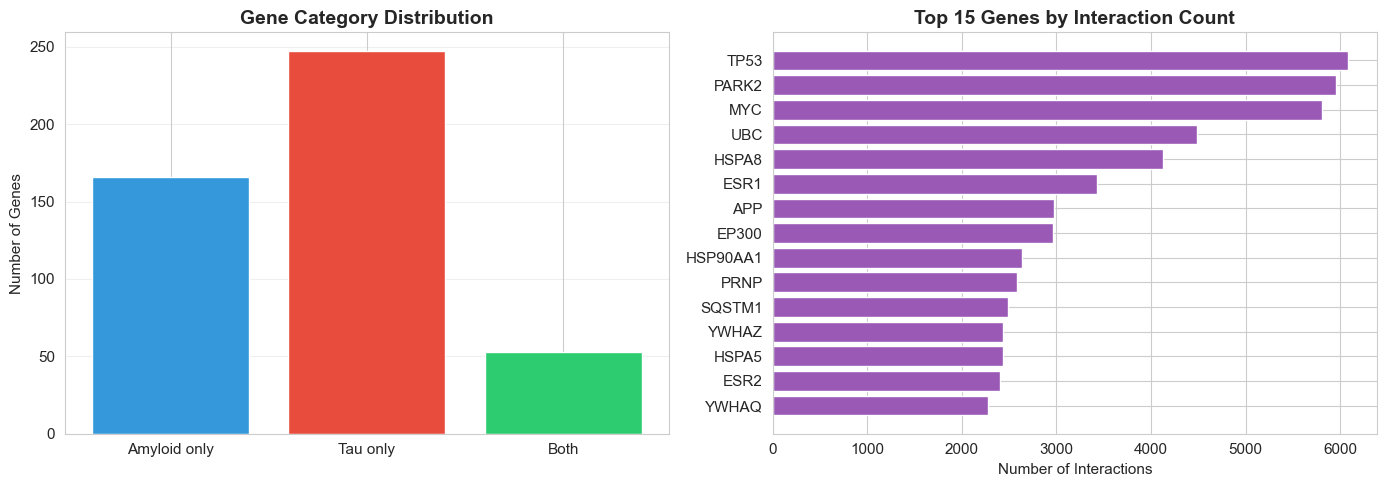

In [8]:
# Visualize gene categories
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Category distribution
category_data = {
    'Amyloid only': sum(genes_df['is_amyloid'] & ~genes_df['is_tau']),
    'Tau only': sum(genes_df['is_tau'] & ~genes_df['is_amyloid']),
    'Both': sum(genes_df['is_both'])
}
axes[0].bar(category_data.keys(), category_data.values(), color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_title('Gene Category Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Genes')
axes[0].grid(axis='y', alpha=0.3)

# Top genes by interaction count
top_genes = genes_df.nlargest(15, 'INTERACTION COUNT')[['OFFICIAL SYMBOL', 'INTERACTION COUNT']]
axes[1].barh(top_genes['OFFICIAL SYMBOL'], top_genes['INTERACTION COUNT'], color='#9b59b6')
axes[1].set_title('Top 15 Genes by Interaction Count', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Interactions')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


## 3. Interaction Data Analysis


In [9]:
# Analyze interaction properties
print("Interaction Dataset Overview:")
print(f"Total interactions: {len(interactions_df)}")
print(f"\nExperimental System Types:")
print(interactions_df['Experimental System Type'].value_counts())
print(f"\nThroughput distribution:")
print(interactions_df['Throughput'].value_counts())


Interaction Dataset Overview:
Total interactions: 184742

Experimental System Types:
Experimental System Type
physical    182551
genetic       2186
Name: count, dtype: int64

Throughput distribution:
Throughput
High Throughput                   124050
Low Throughput                     59804
High Throughput|Low Throughput       883
Name: count, dtype: int64


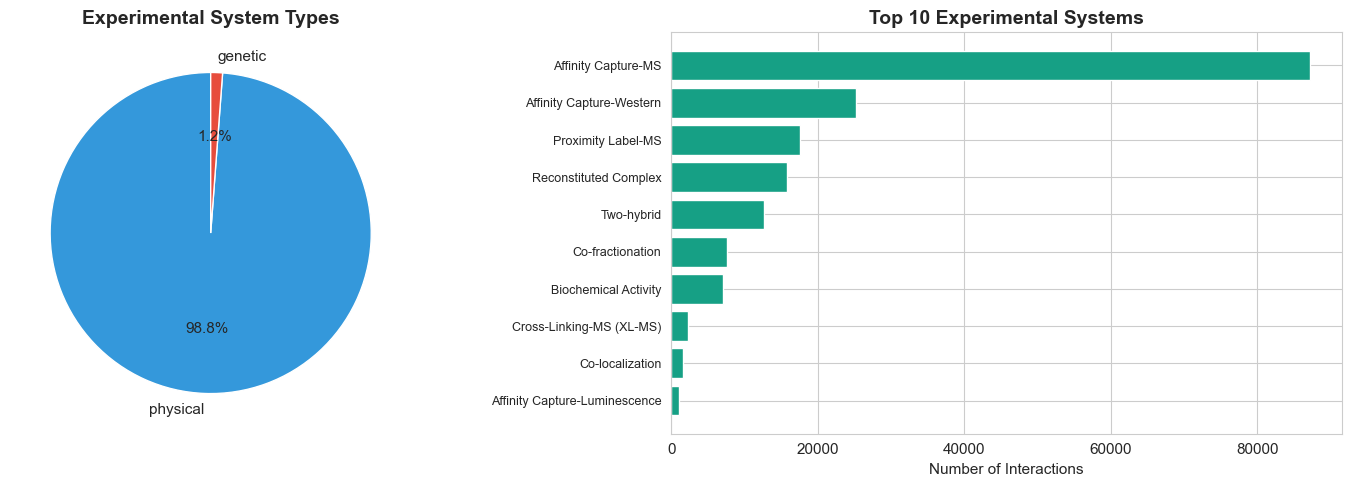

In [10]:
# Analyze experimental systems
top_systems = interactions_df['Experimental System'].value_counts().head(10)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Experimental system types
exp_type_counts = interactions_df['Experimental System Type'].value_counts()
axes[0].pie(exp_type_counts.values, labels=exp_type_counts.index, autopct='%1.1f%%', 
            colors=['#3498db', '#e74c3c'], startangle=90)
axes[0].set_title('Experimental System Types', fontsize=14, fontweight='bold')

# Top experimental systems
axes[1].barh(range(len(top_systems)), top_systems.values, color='#16a085')
axes[1].set_yticks(range(len(top_systems)))
axes[1].set_yticklabels(top_systems.index, fontsize=9)
axes[1].set_xlabel('Number of Interactions')
axes[1].set_title('Top 10 Experimental Systems', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


In [11]:
# Check for self-interactions
self_interactions = interactions_df[
    interactions_df['Entrez Gene Interactor A'] == interactions_df['Entrez Gene Interactor B']
]
print(f"Self-interactions: {len(self_interactions)} ({len(self_interactions)/len(interactions_df)*100:.2f}%)")


Self-interactions: 777 (0.42%)


## 4. Construct Protein-Protein Interaction Network


In [12]:
# Build the PPI network
print("Building PPI network...")

# Create a mapping of Entrez IDs to gene symbols
entrez_to_symbol = dict(zip(genes_df['ENTREZ GENE ID'], genes_df['OFFICIAL SYMBOL']))

# Initialize graph
G = nx.Graph()

# Add edges from interactions
for _, row in interactions_df.iterrows():
    gene_a = row['Entrez Gene Interactor A']
    gene_b = row['Entrez Gene Interactor B']
    
    # Skip self-loops
    if gene_a == gene_b:
        continue
    
    # Add edge with attributes
    G.add_edge(gene_a, gene_b, 
               experimental_system=row['Experimental System'],
               exp_type=row['Experimental System Type'],
               throughput=row['Throughput'],
               pubmed=row['Publication Source']) # remove later?

print(f"\nNetwork constructed:")
print(f"  Nodes (proteins): {G.number_of_nodes()}")
print(f"  Edges (interactions): {G.number_of_edges()}")
print(f"  Density: {nx.density(G):.6f}")


Building PPI network...

Network constructed:
  Nodes (proteins): 26687
  Edges (interactions): 137659
  Density: 0.000387


In [13]:
# Add node attributes from genes data
for _, gene in genes_df.iterrows():
    entrez_id = gene['ENTREZ GENE ID']
    if entrez_id in G.nodes():
        G.nodes[entrez_id]['symbol'] = gene['OFFICIAL SYMBOL']
        G.nodes[entrez_id]['is_amyloid'] = gene['is_amyloid']
        G.nodes[entrez_id]['is_tau'] = gene['is_tau']
        G.nodes[entrez_id]['is_both'] = gene['is_both']
        G.nodes[entrez_id]['interaction_count'] = gene['INTERACTION COUNT']

# Check how many AD-associated genes are in the network
ad_genes_in_network = sum(1 for node in G.nodes() if node in genes_df['ENTREZ GENE ID'].values)
print(f"\nAD-associated genes in network: {ad_genes_in_network}/{len(genes_df)}")



AD-associated genes in network: 463/466


## 5. Network Topology Analysis


In [14]:
# Analyze connected components
connected_components = list(nx.connected_components(G))
component_sizes = [len(c) for c in connected_components]

print("Connected Components:")
print(f"  Number of components: {len(connected_components)}")
print(f"  Largest component size: {max(component_sizes)} nodes ({max(component_sizes)/G.number_of_nodes()*100:.1f}%)")
print(f"  Component size distribution: {sorted(component_sizes, reverse=True)[:10]}...")


Connected Components:
  Number of components: 2
  Largest component size: 26684 nodes (100.0%)
  Component size distribution: [26684, 3]...


In [15]:
# Extract largest connected component (LCC)
largest_cc = max(connected_components, key=len)
G_lcc = G.subgraph(largest_cc).copy()

print(f"\nLargest Connected Component (LCC):")
print(f"  Nodes: {G_lcc.number_of_nodes()}")
print(f"  Edges: {G_lcc.number_of_edges()}")
print(f"  Density: {nx.density(G_lcc):.6f}")
print(f"  Average degree: {sum(dict(G_lcc.degree()).values()) / G_lcc.number_of_nodes():.2f}")



Largest Connected Component (LCC):
  Nodes: 26684
  Edges: 137657
  Density: 0.000387
  Average degree: 10.32


In [16]:
# Calculate basic network metrics
print("\nCalculating network metrics...")

# Degree
degrees = dict(G_lcc.degree())

# Clustering coefficient
clustering = nx.clustering(G_lcc)

# Betweenness centrality (on a sample for large networks)
if G_lcc.number_of_nodes() > 5000:
    print("  Computing betweenness on sample (network is large)...")
    betweenness = nx.betweenness_centrality(G_lcc, k=min(1000, G_lcc.number_of_nodes()))
else:
    betweenness = nx.betweenness_centrality(G_lcc)

# Create a dataframe with node metrics
node_metrics = pd.DataFrame({
    'entrez_id': list(G_lcc.nodes()),
    'degree': [degrees[n] for n in G_lcc.nodes()],
    'clustering': [clustering[n] for n in G_lcc.nodes()],
    'betweenness': [betweenness[n] for n in G_lcc.nodes()]
})

# Add gene symbols
node_metrics['symbol'] = node_metrics['entrez_id'].apply(
    lambda x: G_lcc.nodes[x].get('symbol', 'Unknown')
)

print("\nMetrics calculated successfully!")
node_metrics.head(10)



Calculating network metrics...
  Computing betweenness on sample (network is large)...

Metrics calculated successfully!


,entrez_id,degree,clustering,betweenness,symbol
0,6416,55,0.084175,1.465469e-04,MAP2K4
1,2318,13,0.115385,3.860084e-05,Unknown
2,90,103,0.002856,2.801784e-03,ACVR1
3,2339,11,0.181818,1.093529e-04,Unknown
4,351,2238,0.002059,6.541854e-02,APP
5,10513,154,0.003650,3.865165e-03,APPBP2
6,2033,886,0.013314,1.247548e-02,EP300
7,7020,15,0.380952,4.963078e-05,Unknown
8,1436,4,0.833333,1.947075e-07,Unknown
9,2885,718,0.012335,1.292499e-02,GRB2


In [17]:
# Network statistics summary
print("\n=== NETWORK STATISTICS SUMMARY ===")
print(f"\nDegree:")
print(f"  Mean: {node_metrics['degree'].mean():.2f}")
print(f"  Median: {node_metrics['degree'].median():.2f}")
print(f"  Max: {node_metrics['degree'].max()}")
print(f"  Min: {node_metrics['degree'].min()}")

print(f"\nClustering Coefficient:")
print(f"  Mean: {node_metrics['clustering'].mean():.4f}")
print(f"  Global: {nx.transitivity(G_lcc):.4f}")

print(f"\nBetweenness Centrality:")
print(f"  Mean: {node_metrics['betweenness'].mean():.6f}")
print(f"  Max: {node_metrics['betweenness'].max():.6f}")



=== NETWORK STATISTICS SUMMARY ===

Degree:
  Mean: 10.32
  Median: 2.00
  Max: 3265
  Min: 1

Clustering Coefficient:
  Mean: 0.1301
  Global: 0.0107

Betweenness Centrality:
  Mean: 0.000088
  Max: 0.080589


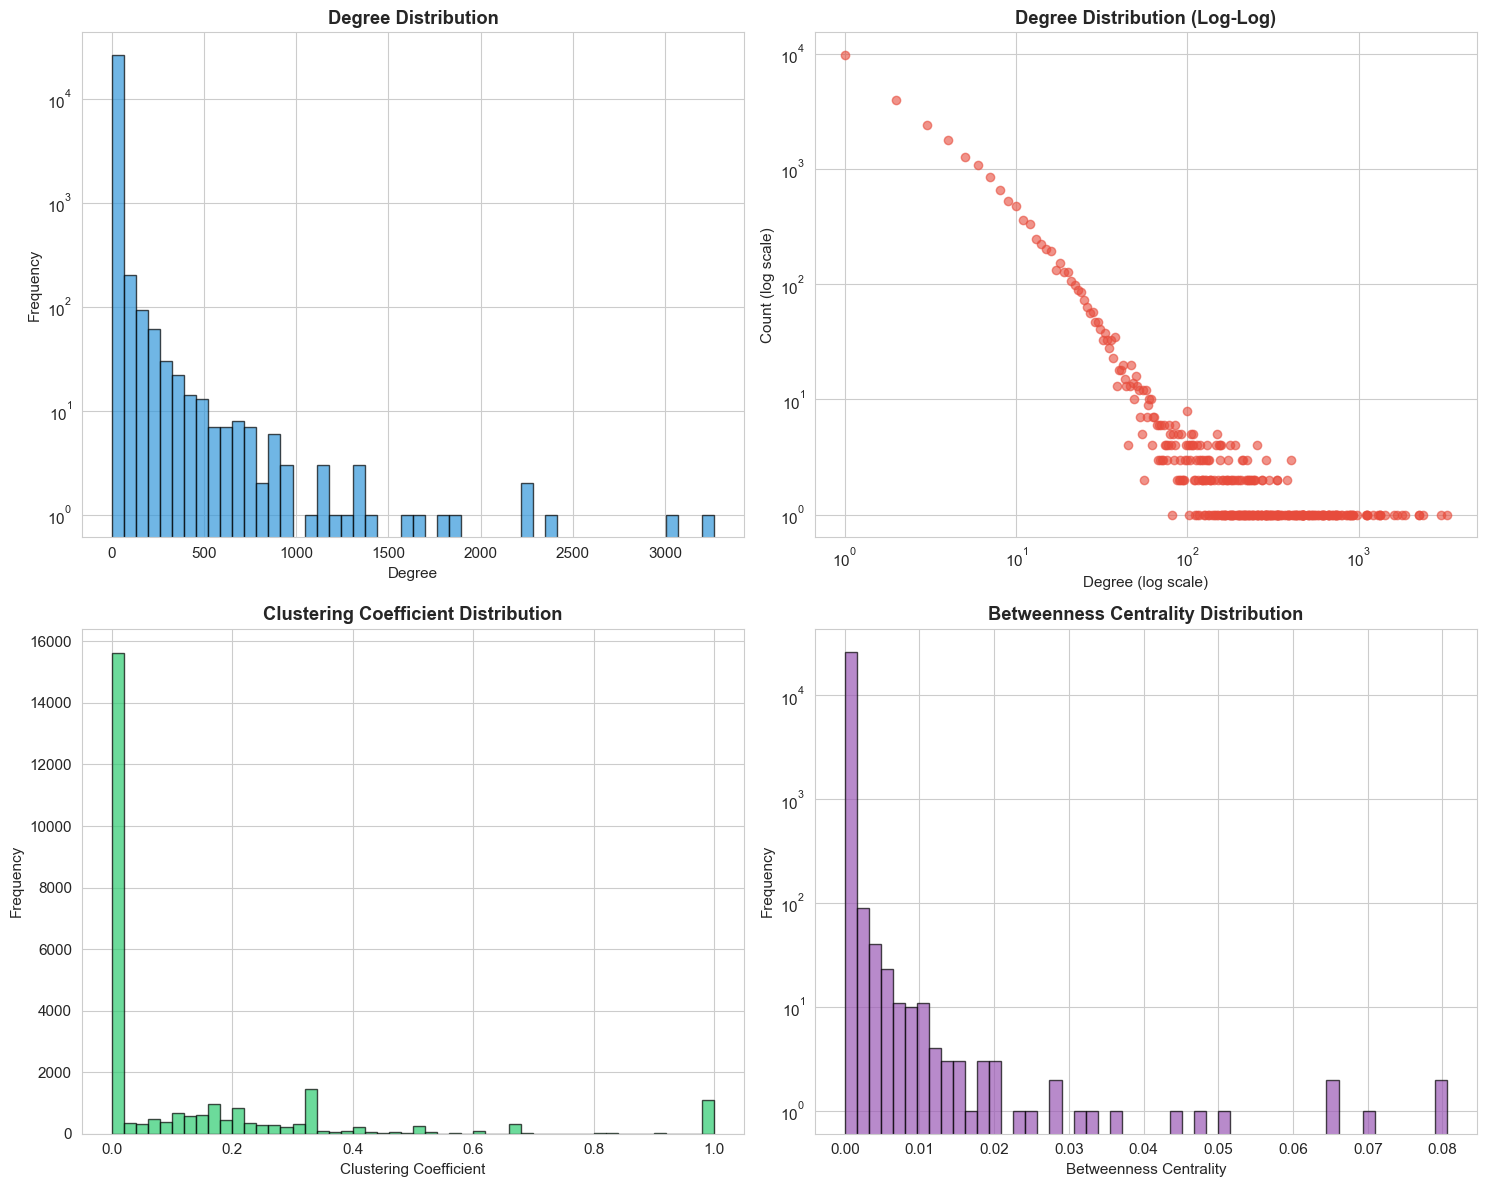

In [18]:
# Visualize network properties
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Degree distribution
degree_values = list(degrees.values())
axes[0, 0].hist(degree_values, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Degree')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Degree Distribution', fontweight='bold')
axes[0, 0].set_yscale('log')

# Degree distribution (log-log)
degree_counts = Counter(degree_values)
degrees_sorted = sorted(degree_counts.keys())
counts_sorted = [degree_counts[d] for d in degrees_sorted]
axes[0, 1].scatter(degrees_sorted, counts_sorted, alpha=0.6, color='#e74c3c')
axes[0, 1].set_xlabel('Degree (log scale)')
axes[0, 1].set_ylabel('Count (log scale)')
axes[0, 1].set_title('Degree Distribution (Log-Log)', fontweight='bold')
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')

# Clustering coefficient distribution
clustering_values = list(clustering.values())
axes[1, 0].hist(clustering_values, bins=50, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Clustering Coefficient')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Clustering Coefficient Distribution', fontweight='bold')

# Betweenness centrality distribution
betweenness_values = list(betweenness.values())
axes[1, 1].hist(betweenness_values, bins=50, color='#9b59b6', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Betweenness Centrality')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Betweenness Centrality Distribution', fontweight='bold')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()


## 6. Hub Analysis and AD Gene Properties


In [19]:
# Identify hub genes
top_hubs = node_metrics.nlargest(20, 'degree')[['symbol', 'degree', 'clustering', 'betweenness']]
print("\nTop 20 Hub Genes (by degree):")
print(top_hubs.to_string(index=False))



Top 20 Hub Genes (by degree):
  symbol  degree  clustering  betweenness
 Unknown    3265    0.002713     0.079516
 Unknown    3034    0.002556     0.069400
 Unknown    2358    0.000965     0.080589
    ESR2    2257    0.002010     0.036342
     APP    2238    0.002059     0.065419
     UBC    1862    0.003916     0.065818
 Unknown    1787    0.003586     0.044031
 Unknown    1667    0.001961     0.019838
     MYC    1602    0.006456     0.018355
    TP53    1427    0.009871     0.032763
 Unknown    1337    0.003368     0.009166
 Unknown    1327    0.000574     0.050588
 Unknown    1324    0.006565     0.017044
   HSPA8    1299    0.013678     0.024558
HSP90AA1    1209    0.013282     0.027817
 Unknown    1123    0.001662     0.048046
 Unknown    1117    0.001718     0.022900
 Unknown    1113    0.006057     0.012754
   HSPA5    1105    0.012312     0.030786
 Unknown     977    0.002557     0.027993


In [20]:
# Identify high betweenness genes
top_betweenness = node_metrics.nlargest(20, 'betweenness')[['symbol', 'degree', 'clustering', 'betweenness']]
print("\nTop 20 Genes by Betweenness Centrality:")
print(top_betweenness.to_string(index=False))



Top 20 Genes by Betweenness Centrality:
  symbol  degree  clustering  betweenness
 Unknown    2358    0.000965     0.080589
 Unknown    3265    0.002713     0.079516
 Unknown    3034    0.002556     0.069400
     UBC    1862    0.003916     0.065818
     APP    2238    0.002059     0.065419
 Unknown    1327    0.000574     0.050588
 Unknown    1123    0.001662     0.048046
 Unknown    1787    0.003586     0.044031
    ESR2    2257    0.002010     0.036342
    TP53    1427    0.009871     0.032763
   HSPA5    1105    0.012312     0.030786
 Unknown     977    0.002557     0.027993
HSP90AA1    1209    0.013282     0.027817
   HSPA8    1299    0.013678     0.024558
 Unknown    1117    0.001718     0.022900
 Unknown     901    0.001174     0.020644
    SNCA     536    0.005914     0.020212
 Unknown    1667    0.001961     0.019838
 Unknown     889    0.006640     0.018391
     MYC    1602    0.006456     0.018355


In [21]:
# Analyze AD genes vs non-AD genes
ad_genes_entrez = set(genes_df['ENTREZ GENE ID'].values)

node_metrics['is_ad_gene'] = node_metrics['entrez_id'].isin(ad_genes_entrez)

print("\n=== AD Genes vs Non-AD Genes ===")
print(f"\nAD genes in LCC: {sum(node_metrics['is_ad_gene'])}")
print(f"Non-AD genes in LCC: {sum(~node_metrics['is_ad_gene'])}")

print("\nDegree comparison:")
print(f"  AD genes mean degree: {node_metrics[node_metrics['is_ad_gene']]['degree'].mean():.2f}")
print(f"  Non-AD genes mean degree: {node_metrics[~node_metrics['is_ad_gene']]['degree'].mean():.2f}")

print("\nClustering comparison:")
print(f"  AD genes mean clustering: {node_metrics[node_metrics['is_ad_gene']]['clustering'].mean():.4f}")
print(f"  Non-AD genes mean clustering: {node_metrics[~node_metrics['is_ad_gene']]['clustering'].mean():.4f}")

print("\nBetweenness comparison:")
print(f"  AD genes mean betweenness: {node_metrics[node_metrics['is_ad_gene']]['betweenness'].mean():.6f}")
print(f"  Non-AD genes mean betweenness: {node_metrics[~node_metrics['is_ad_gene']]['betweenness'].mean():.6f}")



=== AD Genes vs Non-AD Genes ===

AD genes in LCC: 462
Non-AD genes in LCC: 26222

Degree comparison:
  AD genes mean degree: 185.80
  Non-AD genes mean degree: 7.23

Clustering comparison:
  AD genes mean clustering: 0.0255
  Non-AD genes mean clustering: 0.1320

Betweenness comparison:
  AD genes mean betweenness: 0.002394
  Non-AD genes mean betweenness: 0.000048


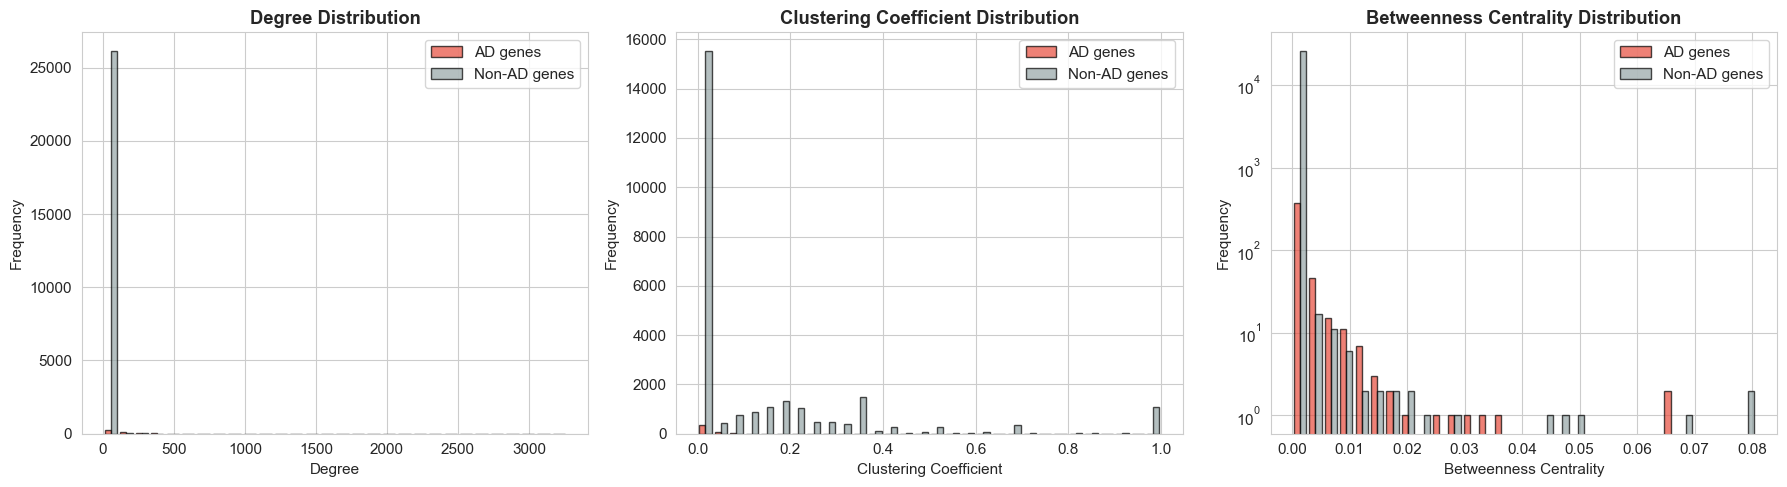

In [22]:
# Visualize AD vs non-AD gene properties
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ['degree', 'clustering', 'betweenness']
titles = ['Degree', 'Clustering Coefficient', 'Betweenness Centrality']

for i, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ad_data = node_metrics[node_metrics['is_ad_gene']][metric]
    non_ad_data = node_metrics[~node_metrics['is_ad_gene']][metric]
    
    axes[i].hist([ad_data, non_ad_data], bins=30, label=['AD genes', 'Non-AD genes'], 
                 color=['#e74c3c', '#95a5a6'], alpha=0.7, edgecolor='black')
    axes[i].set_xlabel(title)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'{title} Distribution', fontweight='bold')
    axes[i].legend()
    if metric == 'betweenness':
        axes[i].set_yscale('log')

plt.tight_layout()
plt.show()


## 7. Save Processed Data


In [29]:
# Save the network
print("Saving network and metrics...")

# Save full network in multiple formats
# GraphML: Standard format, portable, human-readable
nx.write_graphml(G, 'data/ad_network_full.graphml')
print("  Saved full network (GraphML)")

# Pickle: Fast loading in Python (convenience) - using pickle directly
with open('data/ad_network_full.pkl', 'wb') as f:
    pickle.dump(G, f)
print("  Saved full network (pickle)")

# Save LCC in multiple formats
nx.write_graphml(G_lcc, 'data/ad_network_lcc.graphml')
print("  Saved LCC network (GraphML)")

# Pickle for LCC
with open('data/ad_network_lcc.pkl', 'wb') as f:
    pickle.dump(G_lcc, f)
print("  Saved LCC network (pickle)")

# Save edge list (simple text format for inspection)
nx.write_edgelist(G_lcc, 'data/ad_network_lcc_edges.txt', data=True)
print("  Saved LCC edge list (text)")

# Save node metrics
node_metrics.to_csv('data/node_metrics_lcc.csv', index=False)
print("  Saved node metrics")

# Save processed gene annotations
genes_df.to_csv('data/genes_annotated.csv', index=False)
print("  Saved annotated genes")

print("\n✓ All data saved successfully!")
print("\nSaved formats:")
print("  • GraphML (.graphml) - portable, for Cytoscape/Gephi/other tools")
print("  • Pickle (.pkl) - fast loading in Python")
print("  • Edge list (.txt) - simple text format for inspection")
print("\nTo load pickle: with open('data/ad_network_lcc.pkl', 'rb') as f: G = pickle.load(f)")


Saving network and metrics...
  Saved full network (GraphML)
  Saved full network (pickle)
  Saved LCC network (GraphML)
  Saved LCC network (pickle)
  Saved LCC edge list (text)
  Saved node metrics
  Saved annotated genes

✓ All data saved successfully!

Saved formats:
  • GraphML (.graphml) - portable, for Cytoscape/Gephi/other tools
  • Pickle (.pkl) - fast loading in Python
  • Edge list (.txt) - simple text format for inspection

To load pickle: with open('data/ad_network_lcc.pkl', 'rb') as f: G = pickle.load(f)


## 8. Summary Statistics


In [ ]:
print("\n" + "="*60)
print("SUMMARY: ALZHEIMER'S DISEASE PPI NETWORK")
print("="*60)

print("\n📊 DATA OVERVIEW:")
print(f"  • Total AD-associated genes: {len(genes_df)}")
print(f"  • Amyloid genes: {sum(genes_df['is_amyloid'])}")
print(f"  • Tau modifier genes: {sum(genes_df['is_tau'])}")
print(f"  • Both categories: {sum(genes_df['is_both'])}")
print(f"  • Total interactions: {len(interactions_df)}")

print("\n🕸️  NETWORK STRUCTURE:")
print(f"  • Total nodes: {G.number_of_nodes()}")
print(f"  • Total edges: {G.number_of_edges()}")
print(f"  • Connected components: {len(connected_components)}")
print(f"  • LCC nodes: {G_lcc.number_of_nodes()} ({G_lcc.number_of_nodes()/G.number_of_nodes()*100:.1f}%)")
print(f"  • LCC edges: {G_lcc.number_of_edges()} ({G_lcc.number_of_edges()/G.number_of_edges()*100:.1f}%)")

print("\n📈 NETWORK PROPERTIES:")
print(f"  • Network density: {nx.density(G_lcc):.6f}")
print(f"  • Average degree: {node_metrics['degree'].mean():.2f}")
print(f"  • Average clustering: {node_metrics['clustering'].mean():.4f}")
print(f"  • Global clustering (transitivity): {nx.transitivity(G_lcc):.4f}")

print("\n🎯 AD GENE ENRICHMENT:")
print(f"  • AD genes in LCC: {sum(node_metrics['is_ad_gene'])}")
print(f"  • AD genes mean degree: {node_metrics[node_metrics['is_ad_gene']]['degree'].mean():.2f}")
print(f"  • Non-AD genes mean degree: {node_metrics[~node_metrics['is_ad_gene']]['degree'].mean():.2f}")

top_ad_gene = node_metrics[node_metrics['is_ad_gene']].nlargest(1, 'degree')
if len(top_ad_gene) > 0:
    print(f"  • Top AD hub: {top_ad_gene.iloc[0]['symbol']} (degree: {top_ad_gene.iloc[0]['degree']:.0f})")

print("\n" + "="*60)
print("✓ Exploratory analysis complete!")
print("✓ Network ready for topological analysis")
print("="*60)



SUMMARY: ALZHEIMER'S DISEASE PPI NETWORK

📊 DATA OVERVIEW:
  • Total AD-associated genes: 466
  • Amyloid genes: 219
  • Tau modifier genes: 300
  • Both categories: 53
  • Total interactions: 184742

🕸️  NETWORK STRUCTURE:
  • Total nodes: 26687
  • Total edges: 137659
  • Connected components: 2
  • LCC nodes: 26684 (100.0%)
  • LCC edges: 137657 (100.0%)

📈 NETWORK PROPERTIES:
  • Network density: 0.000387
  • Average degree: 10.32
  • Average clustering: 0.1301
  • Global clustering (transitivity): 0.0107

🎯 AD GENE ENRICHMENT:
  • AD genes in LCC: 462
  • AD genes mean degree: 185.80
  • Non-AD genes mean degree: 7.23
  • Top AD hub: ESR2 (degree: 2257)

✓ Exploratory analysis complete!
✓ Network ready for topological analysis
